**Jérémy Olivier**

In [1]:
import numpy as np
import pandas as pd
import math
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statistics as st
from math import *
from sklearn.preprocessing import MinMaxScaler # Normalization
from sklearn.linear_model import LinearRegression # Regression linear model
from sklearn.model_selection import train_test_split # Splitting the data set
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score # Metrics for errors
from sklearn.model_selection import KFold # Cross validation
from tqdm import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn import metrics
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import tensorflow as tf

filepath = "C:/Users/Jérémy Olivier/Documents/Université/Master/2 semester/Advanced programming/Project/"

Download dataset

In [2]:
btc = pd.read_csv(filepath + "BTC-USD.csv")
btc.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200


EDA

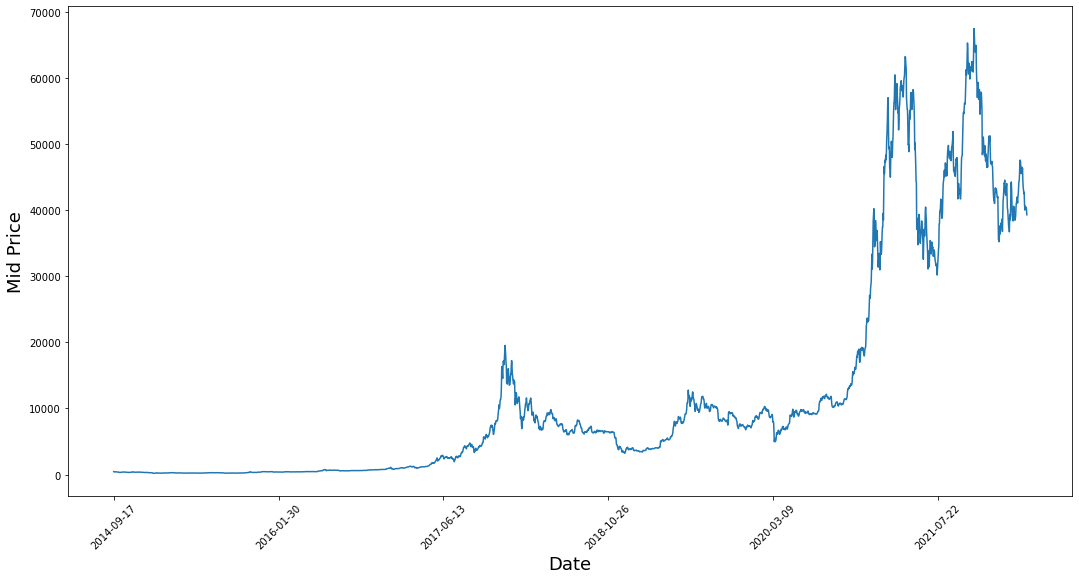

In [3]:
plt.figure(figsize = (18,9))
plt.plot(range(btc.shape[0]),(btc['Low']+btc['High'])/2.0)
plt.xticks(range(0,btc.shape[0],500),btc['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

Creation of new variables

In [4]:
#NEW BITCOIN VARIABLES
#btc["Mid"] = (btc["Open"] + btc["Low"]) / 2 #Mid price
#btc['SMA_7_Price'] = btc.iloc[:,1].rolling(window=7).mean() 
#btc['SMA_14_Price'] = btc.iloc[:,1].rolling(window=14).mean()
#btc['SMA_21_Price'] = btc.iloc[:,1].rolling(window=21).mean()
#btc['SMA_7_Volume'] = btc["Volume"].rolling(window=7).mean() 
#btc['SMA_14_Volume'] = btc["Volume"].rolling(window=14).mean()
#btc['SMA_21_Volume'] = btc["Volume"].rolling(window=21).mean()

btc["_1_Day_Vol"] = btc['Volume'].shift(periods = 1) #Volume of the day before
btc["_1_Day_Vol_Diff"] = btc["Volume"] - btc["_1_Day_Vol"] #Difference between the price T-1 and T0
btc["_1_Day_Vol_Diff_Percent"] = btc["_1_Day_Vol_Diff"] / btc["_1_Day_Vol"] #Difference between the Volume T-1 and T0 in Percent
btc['SMA_7_Volume'] = btc["_1_Day_Vol_Diff_Percent"].rolling(window=7).mean() 
btc['SMA_14_Volume'] = btc["_1_Day_Vol_Diff_Percent"].rolling(window=14).mean()
btc['SMA_21_Volume'] = btc["_1_Day_Vol_Diff_Percent"].rolling(window=21).mean()


    #Price
btc["1_Day_Price"] = btc['Close'].shift(periods = -1) #Price of the day after
btc["1_Day_Price_Diff"] = btc ["1_Day_Price"] - btc["Close"] #Difference between the price T0 and T1
btc["1_Day_Price_Diff_Percent"] = btc["1_Day_Price_Diff"] / btc ["Close"] #Difference between the price T0 and T1 in Percent

btc["_1_Day_Price"] = btc['Close'].shift(periods = 1) #Price of the day before
btc["_1_Day_Price_Diff"] = btc["Close"] - btc ["_1_Day_Price"] #Difference between the price T-1 and T0
btc["_1_Day_Price_Diff_Percent"] = btc["_1_Day_Price_Diff"] / btc ["_1_Day_Price"] #Difference between the price T-1 and T0 in Percent
btc['SMA_7_Price'] = btc["_1_Day_Price_Diff_Percent"].rolling(window=7).mean() 
btc['SMA_14_Price'] = btc["_1_Day_Price_Diff_Percent"].rolling(window=14).mean()
btc['SMA_21_Price'] = btc["_1_Day_Price_Diff_Percent"].rolling(window=21).mean()

for i in range(1,15):
    btc["Vol",i] = btc['_1_Day_Vol_Diff_Percent'].shift(periods = i) #old volume on 14 days
for i in range(1,15):
    btc["Price",i] = btc['_1_Day_Price_Diff_Percent'].shift(periods = i) #old price on 14 days
    


In [5]:
#drop
#btc = btc.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume','1_Day_Price', '1_Day_Price_Diff', '-1_Day_Vol', '-1_Day_Vol_Diff' ], axis=1)

0.0023670062935205217


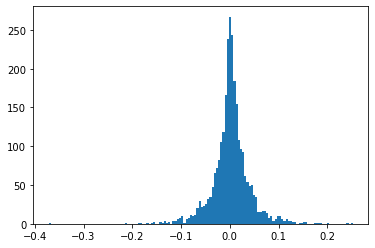

In [6]:
plt.hist(btc["1_Day_Price_Diff_Percent"], bins = "auto")
print(btc["1_Day_Price_Diff_Percent"].mean())

<AxesSubplot:xlabel='1_Day_Price_Diff_Percent'>

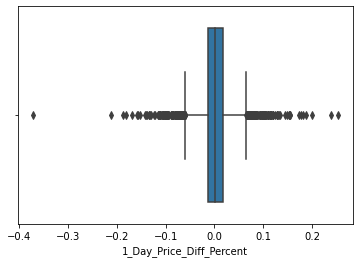

In [7]:
sns.boxplot(x = btc["1_Day_Price_Diff_Percent"])

array([[<AxesSubplot:title={'center':'Open'}>,
        <AxesSubplot:title={'center':'High'}>,
        <AxesSubplot:title={'center':'Low'}>,
        <AxesSubplot:title={'center':'Close'}>,
        <AxesSubplot:title={'center':'Adj Close'}>,
        <AxesSubplot:title={'center':'Volume'}>,
        <AxesSubplot:title={'center':'_1_Day_Vol'}>],
       [<AxesSubplot:title={'center':'_1_Day_Vol_Diff'}>,
        <AxesSubplot:title={'center':'_1_Day_Vol_Diff_Percent'}>,
        <AxesSubplot:title={'center':'SMA_7_Volume'}>,
        <AxesSubplot:title={'center':'SMA_14_Volume'}>,
        <AxesSubplot:title={'center':'SMA_21_Volume'}>,
        <AxesSubplot:title={'center':'1_Day_Price'}>,
        <AxesSubplot:title={'center':'1_Day_Price_Diff'}>],
       [<AxesSubplot:title={'center':'1_Day_Price_Diff_Percent'}>,
        <AxesSubplot:title={'center':'_1_Day_Price'}>,
        <AxesSubplot:title={'center':'_1_Day_Price_Diff'}>,
        <AxesSubplot:title={'center':'_1_Day_Price_Diff_Percent'}>,
  

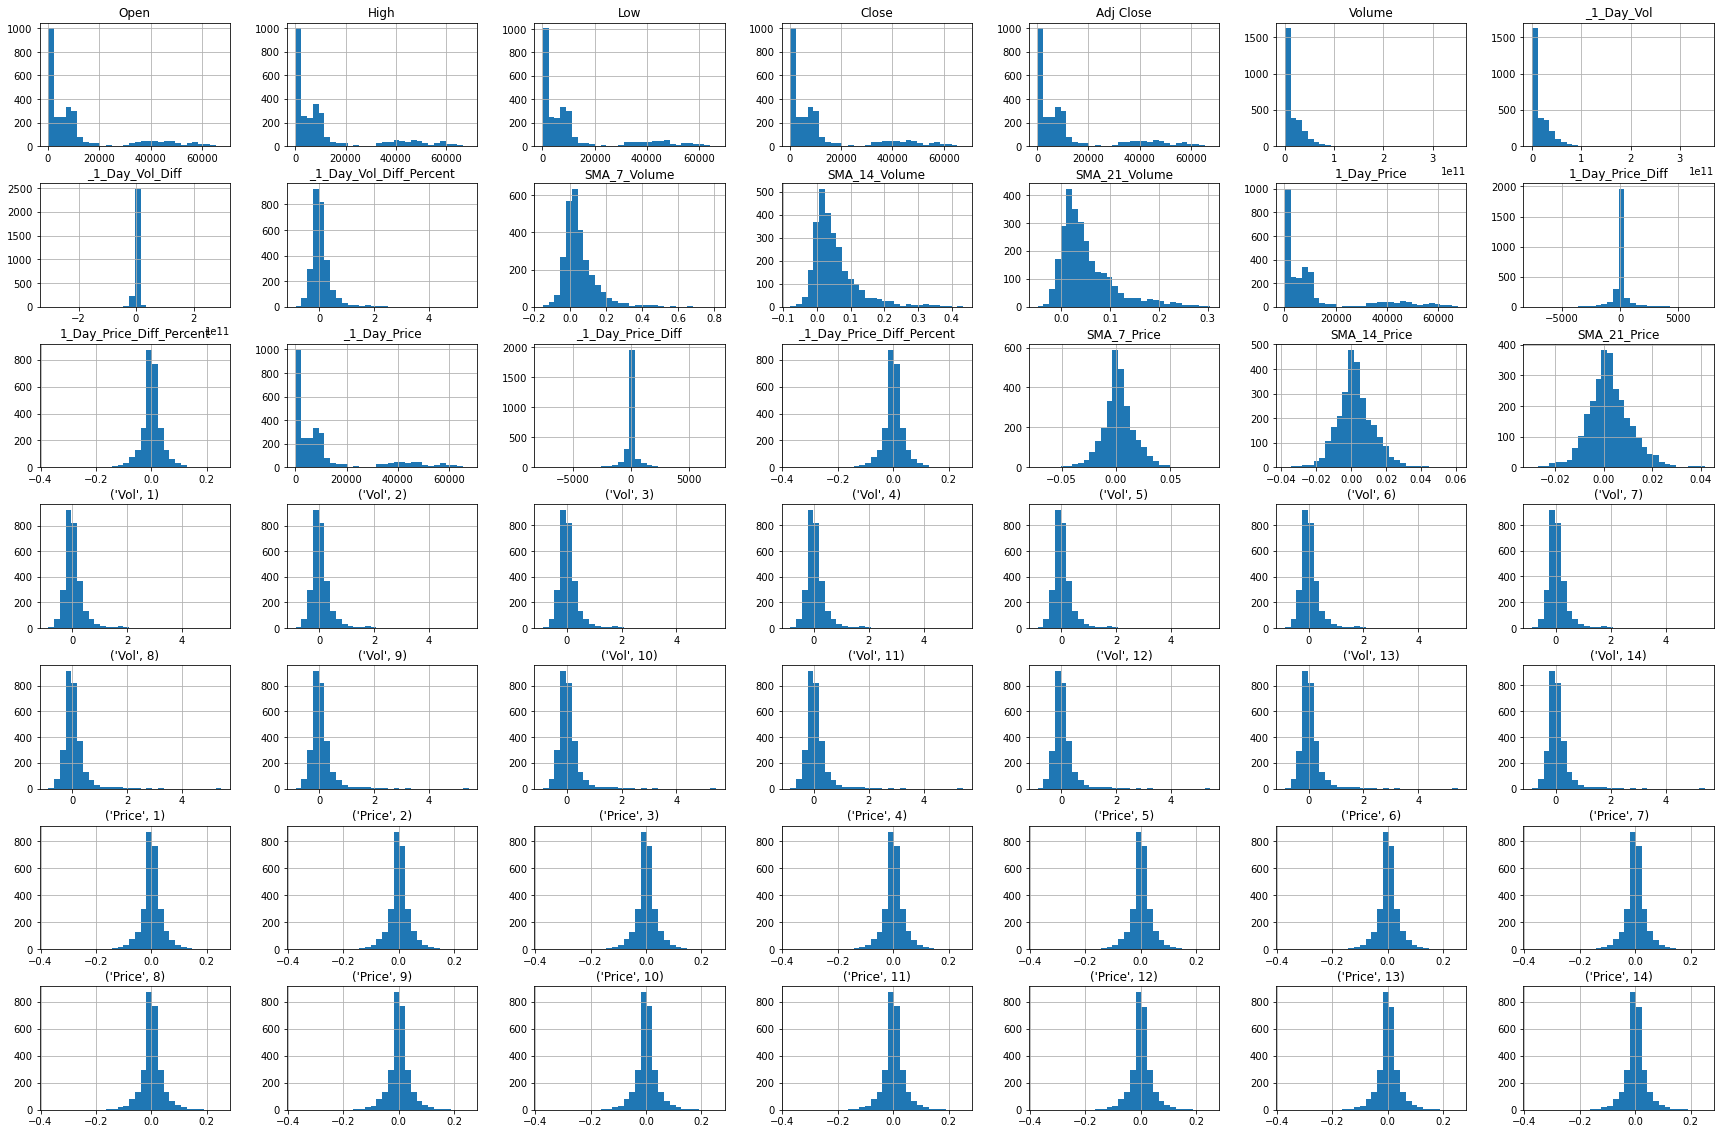

In [8]:
#histogram
btc.hist(bins=30, figsize=(30, 20))

Naive Model

In [9]:
def rmse_(y_true, y_pred):
    MSE = np.square(np.subtract(y_true,y_pred)).mean() 
    RMSE = math.sqrt(MSE)
    print("RMSE :" , RMSE)

In [10]:
rmse_(btc["1_Day_Price_Diff_Percent"][1500:1875], btc["_1_Day_Price_Diff_Percent"][1500:1875])

RMSE : 0.05554763910128054


In [11]:
rmse_(btc["1_Day_Price"][1500:1875], btc["Close"][1500:1875])

RMSE : 314.4776166034977


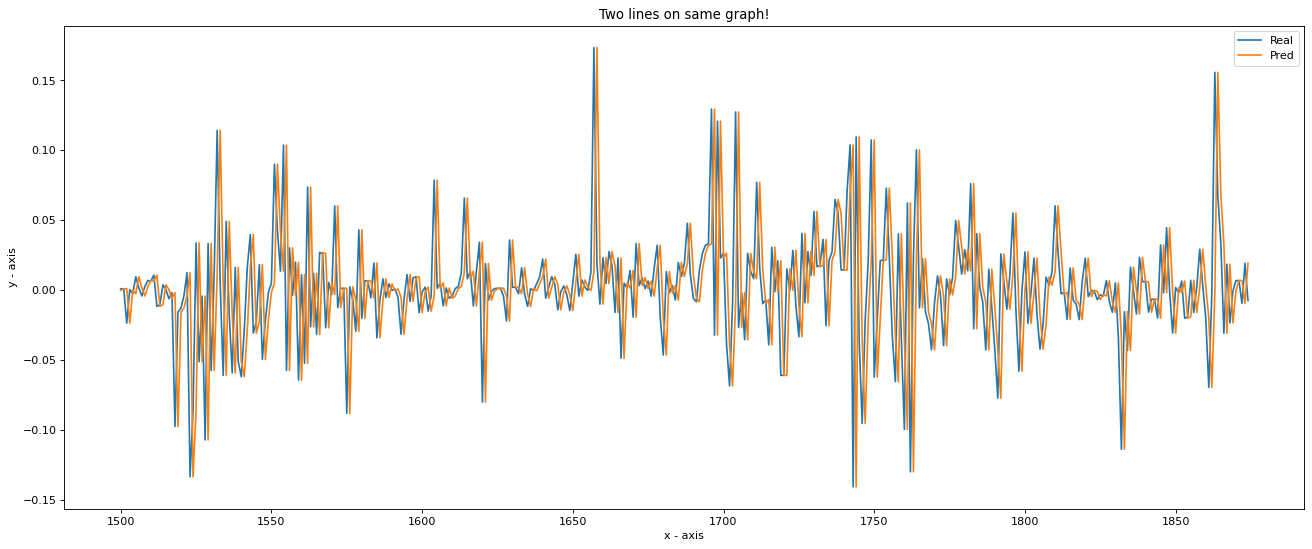

In [12]:
from matplotlib.pyplot import figure

figure(figsize=(20,8), dpi=80)

l = []
for i in range(1500,1875):
    l.append(i)
l

plt.plot(l, btc["1_Day_Price_Diff_Percent"][1500:1875].values, label = "Real")
plt.plot(l, btc["_1_Day_Price_Diff_Percent"][1500:1875], label = "Pred")

plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('y - axis')
# giving a title to my graph
plt.title('Two lines on same graph!')
  
# show a legend on the plot
plt.legend()
  
# function to show the plot
plt.show()

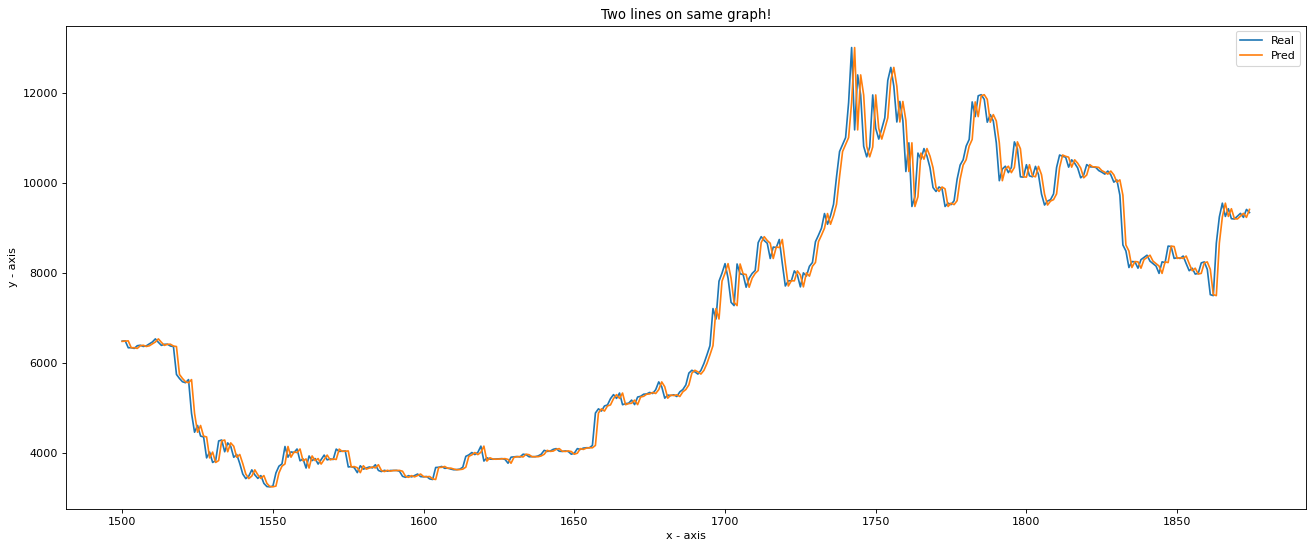

In [13]:
from matplotlib.pyplot import figure

figure(figsize=(20,8), dpi=80)

l = []
for i in range(1500,1875):
    l.append(i)
l

plt.plot(l, btc["1_Day_Price"][1500:1875].values, label = "Real")
plt.plot(l, btc["Close"][1500:1875], label = "Pred")

plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('y - axis')
# giving a title to my graph
plt.title('Two lines on same graph!')
  
# show a legend on the plot
plt.legend()
  
# function to show the plot
plt.show()

DNN Model

In [14]:
import numpy as np
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.datasets import imdb

In [15]:
no_features = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', '1_Day_Price', '1_Day_Price_Diff', '1_Day_Price_Diff_Percent','_1_Day_Price', '_1_Day_Price_Diff', '_1_Day_Vol', '_1_Day_Vol_Diff']
x_train = btc.drop(no_features, 1)


import random
random.seed(2022)
tf.random.set_seed(2022)

def pythonash_model():
    inputs_ = tf.keras.Input(shape = [x_train.shape[1]])
    x = tf.keras.layers.Dense(32, kernel_initializer = 'he_normal')(inputs_)
    batch = tf.keras.layers.BatchNormalization()(x)
    leaky = tf.keras.layers.LeakyReLU(0.1)(batch)
    
    x = tf.keras.layers.Dense(32, kernel_initializer = 'he_normal')(leaky)
    batch = tf.keras.layers.BatchNormalization()(x)
    leaky = tf.keras.layers.LeakyReLU(0.1)(batch)
    
    x = tf.keras.layers.Dense(64, kernel_initializer = 'he_normal')(leaky)
    batch = tf.keras.layers.BatchNormalization()(x)
    leaky = tf.keras.layers.LeakyReLU(0.1)(batch)

    x = tf.keras.layers.Dense(64, kernel_initializer = 'he_normal')(leaky)
    batch = tf.keras.layers.BatchNormalization()(x)
    leaky = tf.keras.layers.LeakyReLU(0.1)(batch)
    
    x = tf.keras.layers.Dense(32, kernel_initializer = 'he_normal')(leaky)
    batch = tf.keras.layers.BatchNormalization()(x)
    leaky = tf.keras.layers.LeakyReLU(0.1)(batch)
    drop = tf.keras.layers.Dropout(0.1)(leaky) #Dropout to avoid overfitting
    
    x = tf.keras.layers.Dense(32, kernel_initializer = 'he_normal')(leaky)
    batch = tf.keras.layers.BatchNormalization()(x)
    leaky = tf.keras.layers.LeakyReLU(0.1)(batch)
    
    x = tf.keras.layers.Dense(16, kernel_initializer = 'he_normal')(leaky)
    batch = tf.keras.layers.BatchNormalization()(x)
    leaky = tf.keras.layers.LeakyReLU(0.1)(batch)
    drop = tf.keras.layers.Dropout(0.1)(leaky) #Dropout to avoid overfitting
    
    x = tf.keras.layers.Dense(8, kernel_initializer = 'he_normal')(leaky)
    batch = tf.keras.layers.BatchNormalization()(x)
    leaky = tf.keras.layers.LeakyReLU(0.1)(batch)
    drop = tf.keras.layers.Dropout(0.1)(leaky) #Dropout to avoid overfitting
    
    outputs_ = tf.keras.layers.Dense(1)(drop)
    
    model = tf.keras.Model(inputs = inputs_, outputs = outputs_)
    
    rmse = tf.keras.metrics.RootMeanSquaredError()

    learning_sch = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.0015,
    decay_steps = 6000,
    decay_rate = 0.95)
    adam = tf.keras.optimizers.Adam(learning_rate = learning_sch)
    
    model.compile(loss = 'mse', metrics = [rmse,"accuracy"], optimizer = adam) #adam optimizer!!
    return model

#pythonash_model().summary()

In [16]:
import graphviz
import pydot
tf.keras.utils.plot_model(pythonash_model(),show_shapes=True,expand_nested=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [17]:
df_x = btc.drop(no_features, axis=1)[25:1500]
df_y = btc["1_Day_Price_Diff_Percent"][25:1500]

test_x = btc.drop(no_features, axis=1)[1500:1875]
test_y = btc["1_Day_Price_Diff_Percent"][1500:1875]

In [18]:
kfold_generator = KFold(n_splits =10, shuffle=True, random_state = 2022)
kfold_generator

KFold(n_splits=10, random_state=2022, shuffle=True)

In [19]:
# WModel save
callbacks = tf.keras.callbacks.ModelCheckpoint(filepath + "M1", save_best_only = True)
for train_index, val_index in kfold_generator.split(df_x, df_y):
    # Split training dataset.
    train_x, train_y = df_x.iloc[train_index], df_y.iloc[train_index]
    # Split validation dataset.
    val_x, val_y = df_x.iloc[val_index], df_y.iloc[val_index]
    # Make tensor dataset.
    ##tf_train = tf.data.Dataset.from_tensor_slices((train_x, train_y)).shuffle(2022).batch(500, drop_remainder=True).prefetch(1)
    ##tf_val = tf.data.Dataset.from_tensor_slices((val_x, val_y)).shuffle(2022).batch(1024, drop_remainder=True).prefetch(1)
    # Load model
    model = pythonash_model()
    # Model fitting
    
    model.fit(train_x, train_y, callbacks = callbacks, batch_size=75, epochs = 25, ### change the epochs into more numbers.
             validation_data = (val_x, val_y), shuffle=True)
    # Delete tensor dataset and model to save memory
    del model
    ##del tf_train
    ##del tf_val
    
best_model = tf.keras.models.load_model(filepath + "M1")   
pred = best_model.predict(test_x)

Epoch 1/25
18/18 [==============================] - 5s 183ms/step - loss: 0.7052 - root_mean_squared_error: 0.8398 - accuracy: 7.5358e-04 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1075 - val_accuracy: 0.0000e+00
Epoch 2/25
18/18 [==============================] - 2s 140ms/step - loss: 0.2797 - root_mean_squared_error: 0.5288 - accuracy: 7.5358e-04 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1068 - val_accuracy: 0.0000e+00
Epoch 3/25
18/18 [==============================] - 3s 162ms/step - loss: 0.1859 - root_mean_squared_error: 0.4311 - accuracy: 7.5358e-04 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1061 - val_accuracy: 0.0000e+00
Epoch 4/25
18/18 [==============================] - 0s 4ms/step - loss: 0.1755 - root_mean_squared_error: 0.4190 - accuracy: 7.5358e-04 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1138 - val_accuracy: 0.0000e+00
Epoch 5/25
18/18 [==============================] - 0s 4ms/step - loss: 0.1403 - root_mean_squared_error: 0.3746 -

Epoch 22/25
18/18 [==============================] - 3s 164ms/step - loss: 0.0212 - root_mean_squared_error: 0.1455 - accuracy: 7.5358e-04 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0725 - val_accuracy: 0.0000e+00
Epoch 23/25
18/18 [==============================] - 2s 138ms/step - loss: 0.0183 - root_mean_squared_error: 0.1354 - accuracy: 7.5358e-04 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0709 - val_accuracy: 0.0000e+00
Epoch 24/25
18/18 [==============================] - 2s 140ms/step - loss: 0.0204 - root_mean_squared_error: 0.1428 - accuracy: 7.5358e-04 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0687 - val_accuracy: 0.0000e+00
Epoch 25/25
18/18 [==============================] - 3s 157ms/step - loss: 0.0176 - root_mean_squared_error: 0.1329 - accuracy: 7.5358e-04 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0675 - val_accuracy: 0.0000e+00
Epoch 1/25
18/18 [==============================] - 2s 15ms/step - loss: 0.4311 - root_mean_squared_error: 0

18/18 [==============================] - 2s 146ms/step - loss: 0.0083 - root_mean_squared_error: 0.0909 - accuracy: 7.5358e-04 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0480 - val_accuracy: 0.0000e+00
Epoch 24/25
18/18 [==============================] - 3s 162ms/step - loss: 0.0077 - root_mean_squared_error: 0.0875 - accuracy: 7.5358e-04 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0472 - val_accuracy: 0.0000e+00
Epoch 25/25
18/18 [==============================] - 3s 152ms/step - loss: 0.0076 - root_mean_squared_error: 0.0872 - accuracy: 7.5358e-04 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0461 - val_accuracy: 0.0000e+00
Epoch 1/25
18/18 [==============================] - 2s 15ms/step - loss: 0.6476 - root_mean_squared_error: 0.8047 - accuracy: 7.5358e-04 - val_loss: 0.0392 - val_root_mean_squared_error: 0.1980 - val_accuracy: 0.0000e+00
Epoch 2/25
18/18 [==============================] - 0s 4ms/step - loss: 0.2677 - root_mean_squared_error: 0.5174 - accurac

Epoch 7/25
18/18 [==============================] - 0s 3ms/step - loss: 0.1075 - root_mean_squared_error: 0.3278 - accuracy: 0.0000e+00 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1106 - val_accuracy: 0.0068
Epoch 8/25
18/18 [==============================] - 0s 3ms/step - loss: 0.0743 - root_mean_squared_error: 0.2726 - accuracy: 0.0000e+00 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1007 - val_accuracy: 0.0068
Epoch 9/25
18/18 [==============================] - 0s 3ms/step - loss: 0.0731 - root_mean_squared_error: 0.2704 - accuracy: 0.0000e+00 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0967 - val_accuracy: 0.0068
Epoch 10/25
18/18 [==============================] - 0s 3ms/step - loss: 0.0881 - root_mean_squared_error: 0.2967 - accuracy: 0.0000e+00 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0941 - val_accuracy: 0.0068
Epoch 11/25
18/18 [==============================] - 0s 3ms/step - loss: 0.0685 - root_mean_squared_error: 0.2617 - accuracy: 0.0000e+0

18/18 [==============================] - 0s 3ms/step - loss: 0.0148 - root_mean_squared_error: 0.1218 - accuracy: 7.5358e-04 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0785 - val_accuracy: 0.0000e+00
Epoch 20/25
18/18 [==============================] - 0s 3ms/step - loss: 0.0145 - root_mean_squared_error: 0.1204 - accuracy: 7.5358e-04 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0764 - val_accuracy: 0.0000e+00
Epoch 21/25
18/18 [==============================] - 0s 3ms/step - loss: 0.0157 - root_mean_squared_error: 0.1254 - accuracy: 7.5358e-04 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0762 - val_accuracy: 0.0000e+00
Epoch 22/25
18/18 [==============================] - 0s 3ms/step - loss: 0.0119 - root_mean_squared_error: 0.1092 - accuracy: 7.5358e-04 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0746 - val_accuracy: 0.0000e+00
Epoch 23/25
18/18 [==============================] - 0s 3ms/step - loss: 0.0121 - root_mean_squared_error: 0.1099 - accuracy: 7.

18/18 [==============================] - 0s 4ms/step - loss: 0.0762 - root_mean_squared_error: 0.2760 - accuracy: 7.5301e-04 - val_loss: 0.0346 - val_root_mean_squared_error: 0.1861 - val_accuracy: 0.0000e+00
Epoch 7/25
18/18 [==============================] - 0s 4ms/step - loss: 0.0661 - root_mean_squared_error: 0.2570 - accuracy: 7.5301e-04 - val_loss: 0.0296 - val_root_mean_squared_error: 0.1722 - val_accuracy: 0.0000e+00
Epoch 8/25
18/18 [==============================] - 0s 3ms/step - loss: 0.0620 - root_mean_squared_error: 0.2490 - accuracy: 7.5301e-04 - val_loss: 0.0239 - val_root_mean_squared_error: 0.1546 - val_accuracy: 0.0000e+00
Epoch 9/25
18/18 [==============================] - 0s 3ms/step - loss: 0.0509 - root_mean_squared_error: 0.2256 - accuracy: 7.5301e-04 - val_loss: 0.0189 - val_root_mean_squared_error: 0.1373 - val_accuracy: 0.0000e+00
Epoch 10/25
18/18 [==============================] - 0s 4ms/step - loss: 0.0502 - root_mean_squared_error: 0.2241 - accuracy: 7.530

18/18 [==============================] - 0s 4ms/step - loss: 0.0203 - root_mean_squared_error: 0.1423 - accuracy: 7.5301e-04 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0953 - val_accuracy: 0.0000e+00
Epoch 19/25
18/18 [==============================] - 0s 4ms/step - loss: 0.0185 - root_mean_squared_error: 0.1362 - accuracy: 7.5301e-04 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0917 - val_accuracy: 0.0000e+00
Epoch 20/25
18/18 [==============================] - 0s 4ms/step - loss: 0.0167 - root_mean_squared_error: 0.1293 - accuracy: 7.5301e-04 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0905 - val_accuracy: 0.0000e+00
Epoch 21/25
18/18 [==============================] - 0s 4ms/step - loss: 0.0143 - root_mean_squared_error: 0.1196 - accuracy: 7.5301e-04 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0839 - val_accuracy: 0.0000e+00
Epoch 22/25
18/18 [==============================] - 0s 4ms/step - loss: 0.0145 - root_mean_squared_error: 0.1204 - accuracy: 7.

18/18 [==============================] - 0s 3ms/step - loss: 0.0828 - root_mean_squared_error: 0.2877 - accuracy: 7.5301e-04 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0908 - val_accuracy: 0.0000e+00
Epoch 6/25
18/18 [==============================] - 0s 3ms/step - loss: 0.0626 - root_mean_squared_error: 0.2501 - accuracy: 7.5301e-04 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0919 - val_accuracy: 0.0000e+00
Epoch 7/25
18/18 [==============================] - 0s 3ms/step - loss: 0.0667 - root_mean_squared_error: 0.2584 - accuracy: 7.5301e-04 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0907 - val_accuracy: 0.0000e+00
Epoch 8/25
18/18 [==============================] - 0s 3ms/step - loss: 0.0625 - root_mean_squared_error: 0.2501 - accuracy: 7.5301e-04 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1064 - val_accuracy: 0.0000e+00
Epoch 9/25
18/18 [==============================] - 0s 3ms/step - loss: 0.0532 - root_mean_squared_error: 0.2306 - accuracy: 7.5301

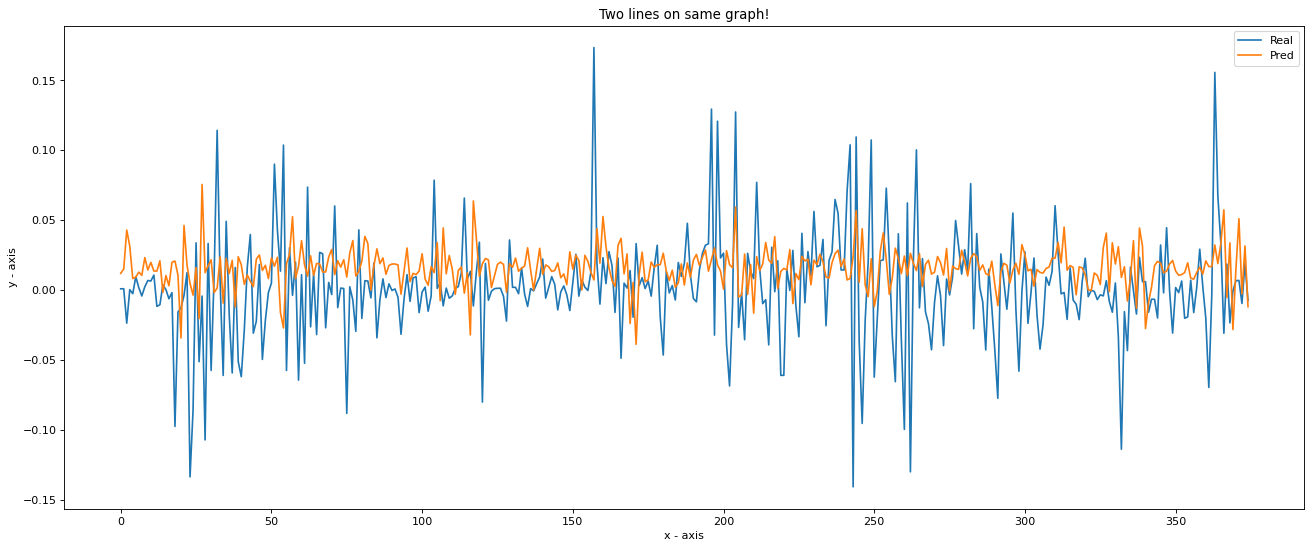

RMSE : 0.043516734893097715


In [20]:
from matplotlib.pyplot import figure

figure(figsize=(20,8), dpi=80)

plt.plot(btc["1_Day_Price_Diff_Percent"][1500:1875].values, label = "Real")
plt.plot(pred, label = "Pred")

plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('y - axis')
# giving a title to my graph
plt.title('Two lines on same graph!')
  
# show a legend on the plot
plt.legend()
  
# function to show the plot
plt.show()
rmse_(btc["1_Day_Price_Diff_Percent"][1500:1875].values,pred)

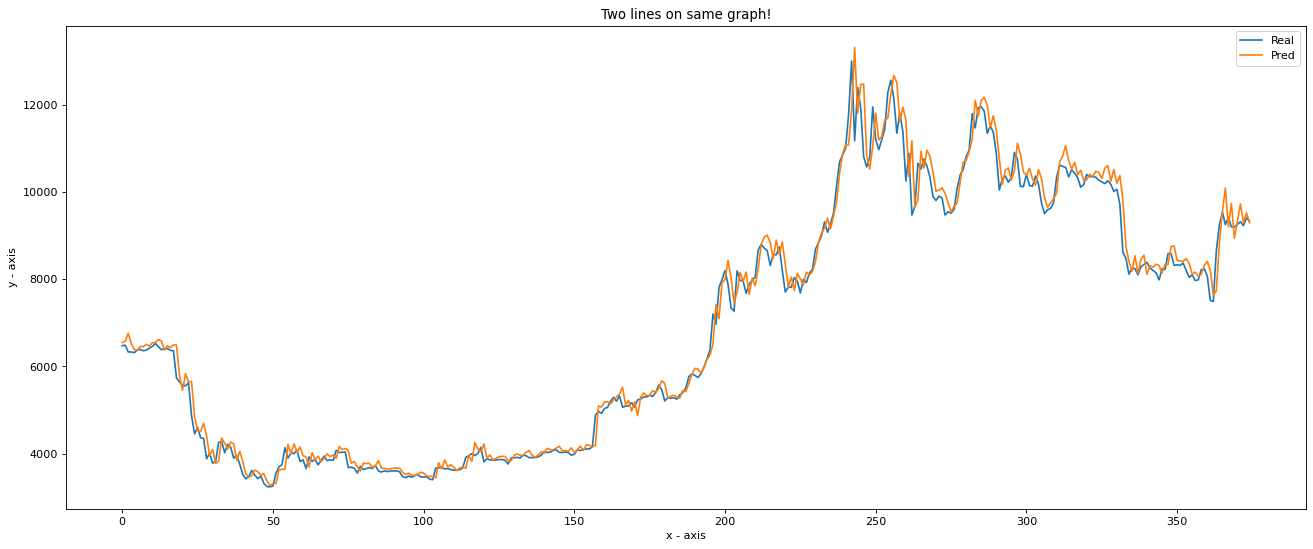

RMSE : 4021.2653562028945


In [21]:
figure(figsize=(20,8), dpi=80)

pred_price = []
for num1, num2 in zip(pred, btc["Close"][1500:1875].values):
	pred_price.append((num1 * num2) + num2)

plt.plot(btc["1_Day_Price"][1500:1875].values, label = "Real")
plt.plot(pred_price, label = "Pred")

plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('y - axis')
# giving a title to my graph
plt.title('Two lines on same graph!')
  
# show a legend on the plot
plt.legend()
  
# function to show the plot
plt.show()
rmse_(btc["1_Day_Price"][1500:1875].values,pred_price)

LGBM (not rly working)

In [22]:
#Rename
btc.columns = ['Date',                      'Open',
                            'High',                       'Low',
                           'Close',                 'Adj Close',
                          'Volume',                '_1_Day_Vol',
                 '_1_Day_Vol_Diff',   '_1_Day_Vol_Diff_Percent',
                    'SMA_7_Volume',             'SMA_14_Volume',
                   'SMA_21_Volume',               '1_Day_Price',
                '1_Day_Price_Diff',  '1_Day_Price_Diff_Percent',
                    '_1_Day_Price',         '_1_Day_Price_Diff',
       '_1_Day_Price_Diff_Percent',               'SMA_7_Price',
                    'SMA_14_Price',              'SMA_21_Price','P1', 'P2', 'P3', 'P4','P5', 'P6', 'P7', ' P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14','V1', 'V2', 'V3', 'V4','V5', 'V6', 'V7', ' V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14']

#Train / test set
no_features = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', '1_Day_Price', '1_Day_Price_Diff','1_Day_Price_Diff_Percent','_1_Day_Price', '_1_Day_Price_Diff', '_1_Day_Vol', '_1_Day_Vol_Diff']
train = btc.drop(no_features, axis=1)[25:1500]
train_y = btc['1_Day_Price_Diff_Percent'][25:1500]

no_features = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', '1_Day_Price', '1_Day_Price_Diff','1_Day_Price_Diff_Percent','_1_Day_Price', '_1_Day_Price_Diff', '_1_Day_Vol', '_1_Day_Vol_Diff']
test = btc.drop(no_features, axis=1)[1500:1875]

Training fold 1
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[28]	training's l2: 3.15537e-16	training's RMSPE: inf	valid_1's l2: 8.89861e-06	valid_1's RMSPE: 0.999999
Training fold 2
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[27]	training's l2: 2.11877e-13	training's RMSPE: inf	valid_1's l2: 5.48403e-06	valid_1's RMSPE: 0.999989
Training fold 3
Training until validation scores don't improve for 30 rounds


C:\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
<ipython-input-23-e5ab55f429d5>:28: RuntimeWarning: invalid value encountered in true_divide
  return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
<ipython-input-23-e5ab55f429d5>:28: RuntimeWarning: divide by zero encountered in true_divide
  return np.sqrt(np.mean(np.square((y_true - y_pred) / y_tru

Early stopping, best iteration is:
[40]	training's l2: 4.63736e-13	training's RMSPE: inf	valid_1's l2: 3.46992e-07	valid_1's RMSPE: 0.99997
Training fold 4
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	training's l2: 5.96968e-09	training's RMSPE: 1	valid_1's l2: 2.17639e-11	valid_1's RMSPE: inf
Training fold 5
Training until validation scores don't improve for 30 rounds


C:\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
<ipython-input-23-e5ab55f429d5>:28: RuntimeWarning: divide by zero encountered in true_divide
  return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
C:\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future releas

Early stopping, best iteration is:
[533]	training's l2: 4.9708e-13	training's RMSPE: inf	valid_1's l2: 1.86503e-05	valid_1's RMSPE: 0.99981
Training fold 6
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	training's l2: 2.86866e-15	training's RMSPE: inf	valid_1's l2: 6.75737e-10	valid_1's RMSPE: 1.00002
Training fold 7
Training until validation scores don't improve for 30 rounds


C:\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
<ipython-input-23-e5ab55f429d5>:28: RuntimeWarning: divide by zero encountered in true_divide
  return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
C:\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future releas

Early stopping, best iteration is:
[129]	training's l2: 2.93499e-12	training's RMSPE: inf	valid_1's l2: 2.10168e-07	valid_1's RMSPE: 0.999458
Training fold 8
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	training's l2: 1.63808e-15	training's RMSPE: inf	valid_1's l2: 5.27713e-08	valid_1's RMSPE: 0.99996
Training fold 9
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[57]	training's l2: 3.68383e-14	training's RMSPE: inf	valid_1's l2: 4.38678e-07	valid_1's RMSPE: 0.999933
Training fold 10


C:\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
<ipython-input-23-e5ab55f429d5>:28: RuntimeWarning: invalid value encountered in true_divide
  return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
<ipython-input-23-e5ab55f429d5>:28: RuntimeWarning: divide by zero encountered in true_divide
  return np.sqrt(np.mean(np.square((y_true - y_pred) / y_tru

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	training's l2: 2.46504e-15	training's RMSPE: inf	valid_1's l2: 3.30676e-07	valid_1's RMSPE: 0.999982
Our out of folds RMSPE is inf


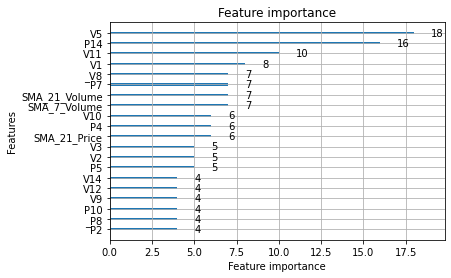

In [23]:
from sklearn.model_selection import KFold
import lightgbm as lgb

seed0=31
params0 = {
    'objective': 'rmse',
    'boosting_type': 'gbdt',
    'max_depth': 0,
    'max_bin':10,
    'min_data_in_leaf': 10,
    'learning_rate': 0.00005,
    'subsample': 0.50,
    'subsample_freq': 20,
    'feature_fraction': 0.5,
    'lambda_l1': 0.5,
    'lambda_l2': 0.5,
    'categorical_column':[0],
    'seed':seed0,
    'feature_fraction_seed': seed0,
    'bagging_seed': seed0,
    'drop_seed': seed0,
    'data_random_seed': seed0,
    'n_jobs':-1,
    'verbose': -1}

# Function to early stop with root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

def train_and_evaluate_lgb(train, test, params):
    # Hyperparammeters (just basic)
    
    features = [col for col in train.columns if col not in {"time_id", "target", "row_id"}]
    y = train_y
    # Create out of folds array
    oof_predictions = np.zeros(train.shape[0])
    # Create test array to store predictions
    test_predictions = np.zeros(test.shape[0])
    # Create a KFold object
    kfold = KFold(n_splits = 10, random_state = 2022, shuffle = True)
    # Iterate through each fold
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train)):
        print(f'Training fold {fold + 1}')
        x_train, x_val = train.iloc[trn_ind], train.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        train_dataset = lgb.Dataset(x_train[features], y_train, weight = train_weights)
        val_dataset = lgb.Dataset(x_val[features], y_val, weight = val_weights)
        model = lgb.train(params = params,
                          num_boost_round=60000,
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          verbose_eval = 2500,
                          early_stopping_rounds=30,
                          feval = feval_rmspe)
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = model.predict(x_val[features])
        # Predict the test set
        test_predictions += model.predict(test[features]) / 5
    rmspe_score = rmspe(y, oof_predictions)
    print(f'Our out of folds RMSPE is {rmspe_score}')
    lgb.plot_importance(model,max_num_features=20)
    # Return test predictions
    return test_predictions
# Traing and evaluate
predictions_lgb= train_and_evaluate_lgb(train, test,params0)

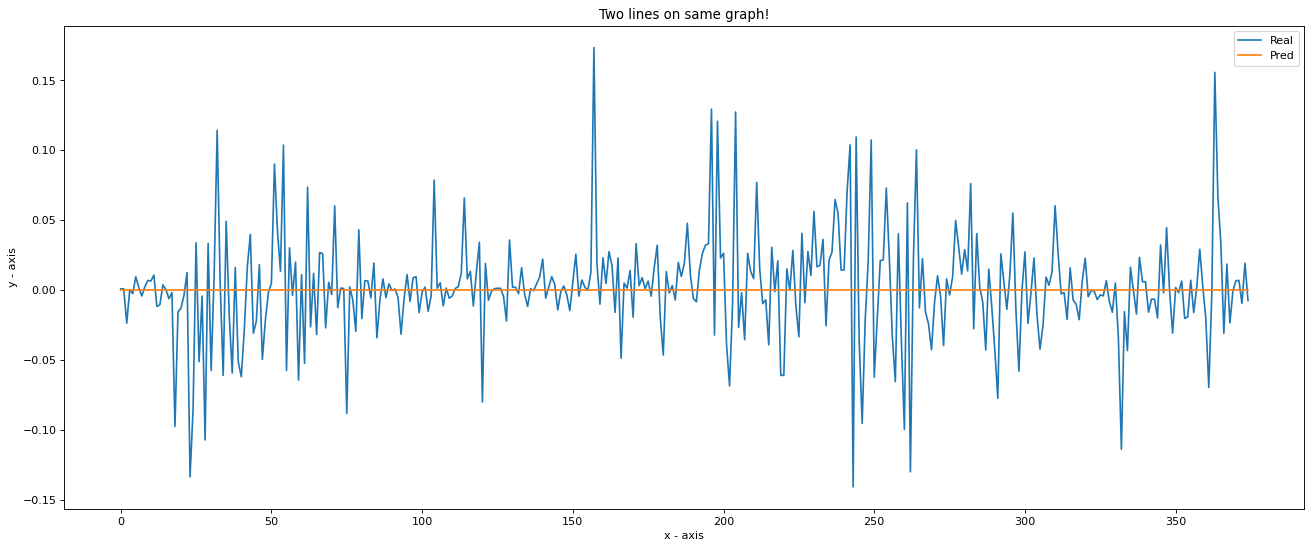

RMSE : 0.03868950195603662


In [24]:
from matplotlib.pyplot import figure

figure(figsize=(20,8), dpi=80)

plt.plot(btc["1_Day_Price_Diff_Percent"][1500:1875].values, label = "Real")
plt.plot(predictions_lgb, label = "Pred")

plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('y - axis')
# giving a title to my graph
plt.title('Two lines on same graph!')
  
# show a legend on the plot
plt.legend()
  
# function to show the plot
plt.show()
rmse_(btc["1_Day_Price_Diff_Percent"][1500:1875].values,predictions_lgb)

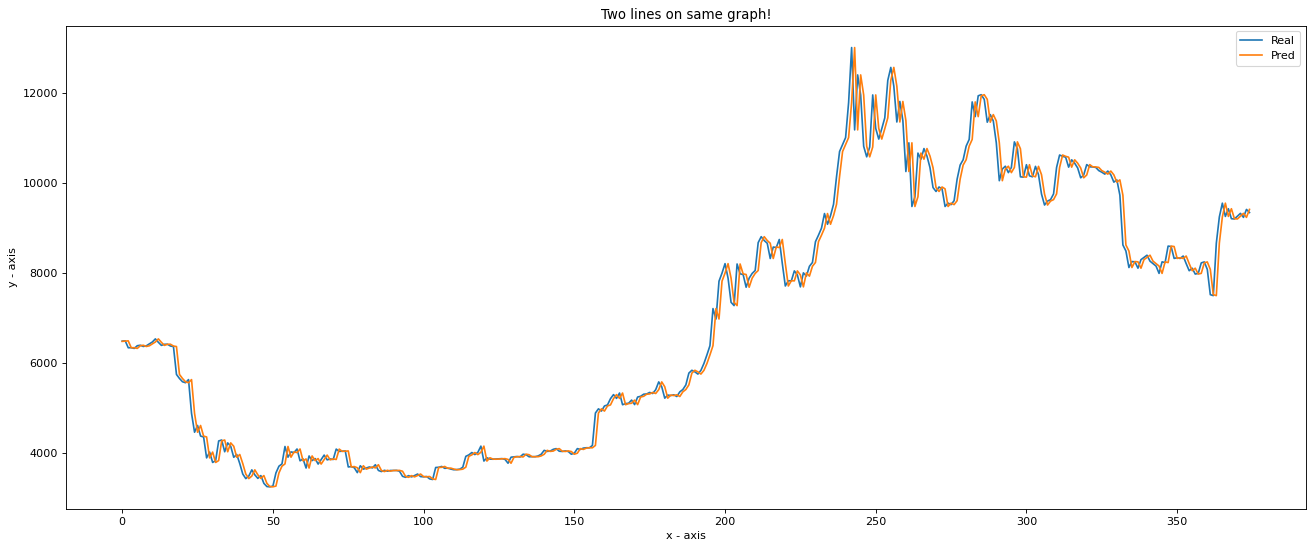

RMSE : 314.4771097115654


In [25]:
figure(figsize=(20,8), dpi=80)

pred_price = []
for num1, num2 in zip(predictions_lgb, btc["Close"][1500:1875].values):
	pred_price.append((num1 * num2) + num2)

plt.plot(btc["1_Day_Price"][1500:1875].values, label = "Real")
plt.plot(pred_price, label = "Pred")

plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('y - axis')
# giving a title to my graph
plt.title('Two lines on same graph!')
  
# show a legend on the plot
plt.legend()
  
# function to show the plot
plt.show()
rmse_(btc["1_Day_Price"][1500:1875].values,pred_price)

**To be continued...**